### Read and clean text

In [1]:
import nltk
import pandas as pd
import re
from sklearn.feature_extraction.text import TfidfVectorizer
import string


stopwords = nltk.corpus.stopwords.words('english')
ps = nltk.PorterStemmer()

# Read data
data = pd.read_csv("SMSSpamCollection.tsv", sep='\t')
data.columns = ['label', 'body_text']

# Feature engineering: Add two columns: body length and the percentage of punctuations
def count_punct(text):
    count = sum([1 for char in text if char in string.punctuation])
    return round(count/(len(text) - text.count(" ")), 3)*100

data['body_len'] = data['body_text'].apply(lambda x: len(x) - x.count(" "))
data['punct%'] = data['body_text'].apply(lambda x: count_punct(x))

data.head()

,label,body_text,body_len,punct%
0,spam,Free entry in 2 a wkly comp to win FA Cup fina...,128,4.7
1,ham,"Nah I don't think he goes to usf, he lives aro...",49,4.1
2,ham,Even my brother is not like to speak with me. ...,62,3.2
3,ham,I HAVE A DATE ON SUNDAY WITH WILL!!,28,7.1
4,ham,As per your request 'Melle Melle (Oru Minnamin...,135,4.4


//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  import sys
//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  


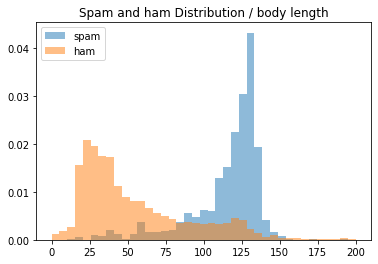

In [2]:
# Evaluate created features
from matplotlib import pyplot
import numpy as np
%matplotlib inline
bins = np.linspace(0, 200, 40)

pyplot.hist(data[data['label']=='spam']['body_len'], bins, alpha=0.5, normed=True, label='spam')
pyplot.hist(data[data['label']=='ham']['body_len'], bins, alpha=0.5, normed=True, label='ham')
pyplot.title('Spam and ham Distribution / body length')
pyplot.legend(loc='upper left')
pyplot.show()

//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  This is separate from the ipykernel package so we can avoid doing imports until
//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  after removing the cwd from sys.path.


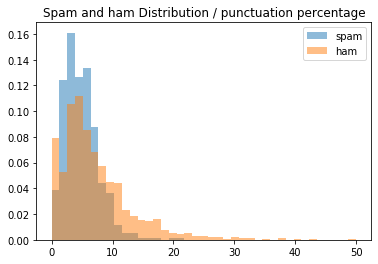

In [3]:
bins = np.linspace(0, 50, 40)

pyplot.hist(data[data['label']=='spam']['punct%'], bins, alpha=0.5, normed=True, label='spam')
pyplot.hist(data[data['label']=='ham']['punct%'], bins, alpha=0.5, normed=True, label='ham')
pyplot.title('Spam and ham Distribution / punctuation percentage')
pyplot.legend(loc='upper right')
pyplot.show()

From the visualization, we can tell that spam and ham clusters have significant different body length distributions, hence body length can be a good indicator for distinguishing the targets.

In [4]:
# Define function for cleaning text, including moving punctuations, tokenizing, and stemming
def clean_text(text):
    text = "".join([word.lower() for word in text if word not in string.punctuation])
    tokens = re.split('\W+', text)
    text = [ps.stem(word) for word in tokens if word not in stopwords]
    return text

### Split data into train/test

In [5]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(data[['body_text', 'body_len', 'punct%']], data['label'], test_size=0.2)

### Vectorize text

In [6]:
tfidf_vect = TfidfVectorizer(analyzer=clean_text)
tfidf_vect_fit = tfidf_vect.fit(X_train['body_text'])

# Save the vectorizer
#tfidf = pickle.dump(tfidf_vect, open('tranform.pkl', 'wb'))

tfidf_train = tfidf_vect_fit.transform(X_train['body_text'])
tfidf_test = tfidf_vect_fit.transform(X_test['body_text'])

X_train_vect = pd.concat([X_train[['body_len', 'punct%']].reset_index(drop=True), 
           pd.DataFrame(tfidf_train.toarray())], axis=1)
X_test_vect = pd.concat([X_test[['body_len', 'punct%']].reset_index(drop=True), 
           pd.DataFrame(tfidf_test.toarray())], axis=1)

X_train_vect.head()

,body_len,punct%,0,1,2,3,4,5,6,7,...,7128,7129,7130,7131,7132,7133,7134,7135,7136,7137
0,83,2.4,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,97,6.2,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,28,3.6,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,22,31.8,0.320401,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,29,3.4,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Model selection

#### Random Forest

In [7]:
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.ensemble import RandomForestClassifier
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
from sklearn.model_selection import GridSearchCV

rf = RandomForestClassifier(n_estimators=50, max_depth=20, n_jobs=-1)
rf_model = rf.fit(X_train_vect, y_train)

In [8]:
# Use random forest for feature selection
sorted(zip(rf_model.feature_importances_, X_train_vect.columns), reverse=True)[0:10]

[(0.04709010197223213, 1593),
 (0.046700737869270946, 'body_len'),
 (0.04222194417493049, 1790),
 (0.03478988385364308, 6476),
 (0.029510789268354994, 5539),
 (0.024277149684919574, 2750),
 (0.022610832172546294, 5275),
 (0.021238684058037815, 5043),
 (0.020529810224882986, 4223),
 (0.015543630610877358, 5941)]

In [9]:
y_pred = rf_model.predict(X_test_vect)
precision, recall, fscore, support = score(y_test, y_pred, pos_label='spam', average='binary')

In [10]:
print('Precision: {} / Recall: {} / Accuracy: {}'.format(round(precision, 3),
                                                        round(recall, 3),
                                                        round((y_pred==y_test).sum() / len(y_pred),3)))

Precision: 1.0 / Recall: 0.54 / Accuracy: 0.938


#### Random Forest with GridsearchCV

In [11]:
rf = RandomForestClassifier()
param = {'n_estimators': [10, 150, 300],
        'max_depth': [30, 60, 90, None]}

gs = GridSearchCV(rf, param, cv=5, n_jobs=-1)
gs_fit = gs.fit(X_train_vect, y_train)
pd.DataFrame(gs_fit.cv_results_).sort_values('mean_test_score', ascending=False)[0:5]

//anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
3,1.790034,0.073348,0.125678,0.041619,60,10,"{'max_depth': 60, 'n_estimators': 10}",0.969731,0.975309,0.970787,0.978652,0.964045,0.971704,0.004992,1
6,1.827317,0.066302,0.094175,0.023843,90,10,"{'max_depth': 90, 'n_estimators': 10}",0.974215,0.983165,0.962921,0.977528,0.960674,0.971704,0.008606,1
8,25.562860,0.412995,0.333616,0.027724,90,300,"{'max_depth': 90, 'n_estimators': 300}",0.969731,0.979798,0.971910,0.977528,0.958427,0.971480,0.007474,3
7,13.176336,0.283604,0.201325,0.016838,90,150,"{'max_depth': 90, 'n_estimators': 150}",0.967489,0.979798,0.970787,0.976404,0.961798,0.971255,0.006377,4
10,14.373661,0.409206,0.226447,0.024655,None,150,"{'max_depth': None, 'n_estimators': 150}",0.968610,0.979798,0.971910,0.974157,0.960674,0.971031,0.006332,5


Random Forest has the best performance in 97.52% mean test score when max_depth = 90 and n_estimators = 300.

#### Gradiant Boosting

In [12]:
from sklearn.ensemble import GradientBoostingClassifier
gb = GradientBoostingClassifier()
param = {
    'n_estimators': [100, 150], 
    'max_depth': [7, 11, 15],
    'learning_rate': [0.1]
}

clf = GridSearchCV(gb, param, cv=5, n_jobs=-1)
cv_fit = clf.fit(X_train_vect, y_train)
pd.DataFrame(cv_fit.cv_results_).sort_values('mean_test_score', ascending=False)[0:5]

//anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_learning_rate,param_max_depth,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
1,208.458129,6.041509,0.199996,0.034569,0.1,7,150,"{'learning_rate': 0.1, 'max_depth': 7, 'n_esti...",0.958520,0.978676,0.965169,0.973034,0.955056,0.966090,0.008793,1
0,147.299512,1.463819,0.178294,0.028906,0.1,7,100,"{'learning_rate': 0.1, 'max_depth': 7, 'n_esti...",0.956278,0.975309,0.959551,0.969663,0.956180,0.963395,0.007730,2
3,1152.650333,547.501110,0.223398,0.030100,0.1,11,150,"{'learning_rate': 0.1, 'max_depth': 11, 'n_est...",0.955157,0.976431,0.959551,0.968539,0.955056,0.962946,0.008339,3
5,489.685494,87.737895,0.345802,0.142482,0.1,15,150,"{'learning_rate': 0.1, 'max_depth': 15, 'n_est...",0.956278,0.977553,0.955056,0.969663,0.955056,0.962722,0.009244,4
2,409.579972,227.250142,0.213617,0.070229,0.1,11,100,"{'learning_rate': 0.1, 'max_depth': 11, 'n_est...",0.955157,0.976431,0.958427,0.967416,0.955056,0.962497,0.008298,5


Gradiant Boosting has the best performance in 96.6% when n_estimator = 150 and max_depth = 7,while Gradiant Boosting is much slower than Random Forest, the average fitting time is 200 times higher than Random Forest.

#### Naive Bayes

In [14]:
from sklearn.naive_bayes import MultinomialNB

model_nb = MultinomialNB()
nb = model_nb.fit(X_train_vect, y_train)
#clf.score(X_test,y_test)

y_pred_nb = nb.predict(X_test_vect)
precision, recall, fscore, support = score(y_test, y_pred_nb, pos_label='spam', average='binary')

In [15]:
print('Precision: {} / Recall: {} / Accuracy: {}'.format(round(precision, 3),
                                                        round(recall, 3),
                                                        round((y_pred_nb==y_test).sum() / len(y_pred),3)))

Precision: 0.89 / Recall: 0.593 / Accuracy: 0.935


In [17]:
# Save model
import pickle
filename = 'nlp_model.pkl'
pickle.dump(clf, open(filename, 'wb'))